# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

# Prep

## Importing Libraries and Data

In [1]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# XGBoost
import xgboost as xgb

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [52]:
embeddings[embeddings['profile_url'] == 'https://www.guru.com/freelancers/brian-zifac']

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,profile_url
360,-0.521367,-0.094213,0.166975,-0.107805,-0.398132,0.175142,-0.077234,-0.412141,-0.102955,0.579859,...,0.464605,0.567497,-0.049418,-0.518024,-0.18917,-0.219285,0.100541,-0.425449,-0.594031,https://www.guru.com/freelancers/brian-zifac


In [2]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
profile_url = analysis_dt['profile_url']
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing inactive users
analysis_dt = analysis_dt.loc[analysis_dt['has_quote'] == 1, :]
analysis_dt.shape

# Removing crazy outliers
analysis_dt = analysis_dt.loc[analysis_dt['hourly_rate'] < 100, :]

# Final Cleaning
analysis_dt = analysis_dt.drop(['num_skills','earnings_per_month',
                                'hours_worked', 'worked_pst_yr',
                                'hours_worked_pr_mnth','has_quote'], axis = 1)
# analysis_dt = analysis_dt.drop(['hours_worked_pr_mnth_pst_yr'], axis = 1)
# analysis_dt = analysis_dt.drop(analysis_dt.columns[15:65], axis = 1)

# Last check
analysis_dt.shape

(369, 115)

## Prepping Data for Training

In [4]:
# Converting data to numpy arrays and saving column names
y = analysis_dt['hourly_rate']

dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(dt.columns)

X = dt

In [5]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Modeling - XGBoost

In [6]:
# Convert Data into DMatrix
dtest = xgb.DMatrix(np.array(X_test), label=np.array(y_test))
dtrain = xgb.DMatrix(np.array(X_train), label= np.array(y_train))
dtrain.save_binary((os.environ['PWD'] + '/data/cleaned/train.buffer'))
dtest.save_binary((os.environ['PWD'] + '/data/cleaned/test.buffer'))

In [7]:
# Baseline Model without Tuning
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 999

# Cross-Validated XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# MAE With Default Params = 17.60

[0]	Test-mae:22.08728
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:18.27683
[2]	Test-mae:17.14021
[3]	Test-mae:17.16591
[4]	Test-mae:16.95271
[5]	Test-mae:16.84984
[6]	Test-mae:17.06520
[7]	Test-mae:17.20019
[8]	Test-mae:17.16252
[9]	Test-mae:17.23234
[10]	Test-mae:17.14273
[11]	Test-mae:17.15683
[12]	Test-mae:17.21234
[13]	Test-mae:17.08045
[14]	Test-mae:17.12098
[15]	Test-mae:17.25267
Stopping. Best iteration:
[5]	Test-mae:16.84984



In [8]:
# Reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2, 20, 2)
    for min_child_weight in range(2, 20, 2)
]

min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
        max_depth,
        min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=2, min_child_weight=2
	MAE 13.891788600000002 for 11 rounds
CV with max_depth=2, min_child_weight=4
	MAE 13.929160200000002 for 5 rounds
CV with max_depth=2, min_child_weight=6
	MAE 13.8301974 for 13 rounds
CV with max_depth=2, min_child_weight=8
	MAE 13.854623199999997 for 8 rounds
CV with max_depth=2, min_child_weight=10
	MAE 13.8488528 for 8 rounds
CV with max_depth=2, min_child_weight=12
	MAE 13.798503399999998 for 7 rounds
CV with max_depth=2, min_child_weight=14
	MAE 13.805552400000002 for 10 rounds
CV with max_depth=2, min_child_weight=16
	MAE 13.947617 for 10 rounds
CV with max_depth=2, min_child_weight=18
	MAE 13.758881000000002 for 14 rounds
CV with max_depth=4, min_child_weight=2
	MAE 13.9853454 for 6 rounds
CV with max_depth=4, min_child_weight=4
	MAE 13.999374600000001 for 4 rounds
CV with max_depth=4, min_child_weight=6
	MAE 13.901593199999999 for 4 rounds
CV with max_depth=4, min_child_weight=8
	MAE 13.741522 for 5 rounds
CV with max_depth=4, min_child_

In [9]:
# Updating params dictionary with selected values
params['max_depth'] = 4
params['min_child_weight'] = 12

In [10]:
# Tuning subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(1,11)]
]

min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=1.0, colsample=1.0
	MAE 13.622522600000002 for 4 rounds
CV with subsample=1.0, colsample=0.9
	MAE 13.731376599999999 for 5 rounds
CV with subsample=1.0, colsample=0.8
	MAE 13.7518852 for 10 rounds
CV with subsample=1.0, colsample=0.7
	MAE 13.706915 for 12 rounds
CV with subsample=1.0, colsample=0.6
	MAE 14.1465732 for 8 rounds
CV with subsample=1.0, colsample=0.5
	MAE 14.078835399999999 for 8 rounds
CV with subsample=1.0, colsample=0.4
	MAE 14.630538000000001 for 4 rounds
CV with subsample=1.0, colsample=0.3
	MAE 14.728722000000001 for 17 rounds
CV with subsample=1.0, colsample=0.2
	MAE 15.158669 for 4 rounds
CV with subsample=1.0, colsample=0.1
	MAE 15.354071000000001 for 21 rounds
CV with subsample=0.9, colsample=1.0
	MAE 13.8506864 for 5 rounds
CV with subsample=0.9, colsample=0.9
	MAE 13.754126200000002 for 5 rounds
CV with subsample=0.9, colsample=0.8
	MAE 13.707577999999998 for 4 rounds
CV with subsample=0.9, colsample=0.7
	MAE 13.742083400000002 for 6 rounds
CV

In [11]:
# Tuning ETA (learning rate)
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .07, .05, .02, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['mae'],
        early_stopping_rounds=10
    )    # Update best score
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params

CV with eta=0.3
	MAE 13.622523000000001 for 4 rounds

CV with eta=0.2
	MAE 13.662397800000003 for 11 rounds

CV with eta=0.1
	MAE 13.6737404 for 17 rounds

CV with eta=0.07
	MAE 13.693127399999998 for 29 rounds

CV with eta=0.05
	MAE 13.678481199999998 for 39 rounds

CV with eta=0.02
	MAE 13.696646000000001 for 104 rounds

CV with eta=0.01
	MAE 13.7243 for 204 rounds

CV with eta=0.005
	MAE 13.7271118 for 411 rounds

Best params: 0.3, MAE: 13.622523000000001


In [12]:
# Train Final Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:21.55386
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:18.29839
[2]	Test-mae:17.05746
[3]	Test-mae:16.51225
[4]	Test-mae:16.27220
[5]	Test-mae:16.80529
[6]	Test-mae:16.90752
[7]	Test-mae:16.97314
[8]	Test-mae:17.09739
[9]	Test-mae:17.27764
[10]	Test-mae:17.46010
[11]	Test-mae:16.91654
[12]	Test-mae:17.05791
[13]	Test-mae:17.23546
[14]	Test-mae:17.16923
Stopping. Best iteration:
[4]	Test-mae:16.27220

Best MAE: 16.27 in 5 rounds


In [13]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:21.55386
[1]	Test-mae:18.29839
[2]	Test-mae:17.05746
[3]	Test-mae:16.51225
[4]	Test-mae:16.27220


In [14]:
# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_xgb_v4.model'
# filename_dump = os.environ['PWD'] + '/scripts/models/dump.raw.txt'

best_model.save_model(filename)
# best_model.dump_model(filename_dump)

# Modeling - LASSO

In [15]:
# Running model
model_lasso = LassoCV(cv=20).fit(X_train, y_train)

# Saving model with pickle
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
pickle.dump(model_lasso, open(filename, 'wb'))

# Modeling - Random Forest Regression
## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [16]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt"], 
              "n_estimators": [100, 500, 900, 1300, 1500], 
              "max_depth": [None,5,10,20]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_absolute_error",
                   refit=True, cv = 3)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_rfr = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
pickle.dump(model_rfr, open(filename, 'wb'))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  2.3min finished


-14.13 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 900}


# Fitting AdaBoost Model
The reason to fit this model is that iteratively re-weights observations based on how poorly the model predicts them. This pushes the model to finding a way to predict observations other models may miss. I am concerned, however, if it will overfit to outliers.

It performs poorly compared to the random forest regression.

In [17]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_ada = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

# Exporting Model
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
pickle.dump(model_ada, open(filename, 'wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 116 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:   28.9s


0.13 {'base_estimator__max_depth': 5, 'n_estimators': 10}


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   40.6s finished


# Model Evaluation

## Functions for Evaluation

In [18]:
def baseline_performance(outcome_data, test_data):
    # Assumes training the mean
    
    # Getting Baseline
    baseline_preds = np.mean(outcome_data)

    # Baseline Errors
    baseline_errors = abs(baseline_preds - test_data)

    # Baseline:
    print('Baseline Performance of Naive Mean Estimator:\nMean Absolute Error:', round(np.mean(baseline_errors), 2))
    
    return np.mean(baseline_errors)
    
def model_performance(predictions, outcome_data, baseline, model_str_name):
    # Calculate absolute error (comparison with baseline)
    errors = abs(predictions - outcome_data)
    
    print(model_str_name + ' Performance:')
    
    # Print out the mean absolute error (mae)
    print('\tMean absolute error: %.2f'
          % mean_absolute_error(outcome_data, predictions))

    # The mean squared error
    print('\tMean squared error: %.2f'
          % mean_squared_error(outcome_data, predictions))

    # The coefficient of determination (R2)
    print('\tCoefficient of determination: %.2f'
          % r2_score(outcome_data, predictions))

    # Does much better than the mean with regard to mean absolute error
    print("\tA ", round((np.mean(errors)-baseline)/baseline,3)*-100,
          "percent change over the mean")
    
    # What is the average dollar change in user hourly rate with this model?
    print("\tAverage Change in Hourly Rate vs Naive Model: $", np.mean(predictions - baseline))

def plot_preds_truth(x, y):
    # Calculate Error
    error = abs(x-y)
    
    # Plotting True Hourly Rates vs Predicted Hourly Rates
    sns.scatterplot(x = x, y = y, palette=['orange'])
    sns.lineplot(x = list(range(0,101)), y = list(range(0,101)), palette=['red'])
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()
    
# Aggregate Function: Model_performance
def model_evaluation(model, model_name_string):

    if model_name_string == 'XGBoost':
        
        # Converting data to useable format 
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Evaluating Model
        model_performance(model.predict(dtest), y_test, pred_baseline, 'model_name_string')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(dtest))
        
    else:
        
        # Evaluating Model
        model_performance(model.predict(X_test), y_test, pred_baseline, 'model_name')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(X_test))


## Loading Models

In [19]:
# XGBoost
model_xgboost = xgb.Booster({'nthread': 4})  # init model
model_xgboost.load_model(os.environ['PWD'] + '/scripts/models/model_xgb_v4.model')  # load data

filename = os.environ['PWD'] + '/scripts/models/model_xgb.sav'
pickle.dump(model_xgboost, open(filename, 'wb'))

filename = os.environ['PWD'] + '/scripts/models/model_xgb.sav'
model_xgb = pickle.load(open(filename, 'rb'))

# Lasso
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
model_lasso = pickle.load(open(filename, 'rb'))

# Random Forest Regression
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
model_rfr = pickle.load(open(filename, 'rb'))

# AdaBoost
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
model_ada = pickle.load(open(filename, 'rb'))

## Evaluation

Baseline Performance of Naive Mean Estimator:
Mean Absolute Error: 16.81


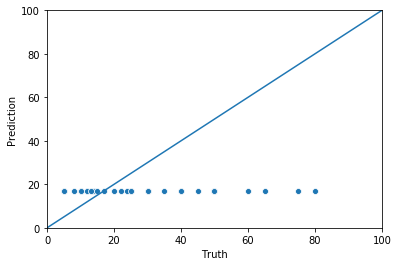

In [20]:
pred_baseline = baseline_performance(y_train, y_test)
plot_preds_truth(x = y_test, y = pred_baseline)

model_name_string Performance:
	Mean absolute error: 16.27
	Mean squared error: 457.11
	Coefficient of determination: -0.12
	A  3.2 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 4.9960065


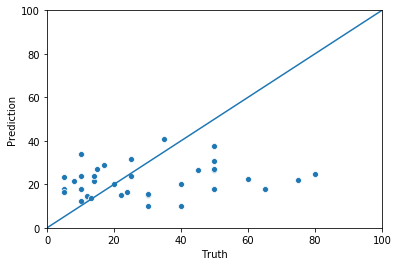

In [21]:
# XGBoost
model_evaluation(model_xgboost, 'XGBoost')

model_name Performance:
	Mean absolute error: 19.42
	Mean squared error: 610.13
	Coefficient of determination: -0.49
	A  -15.5 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 9.728042162009247


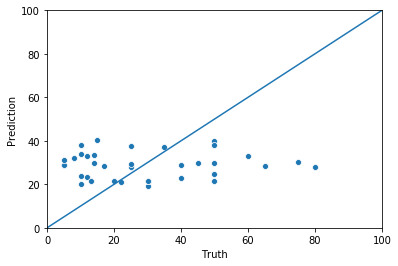

In [22]:
# Lasso
model_evaluation(model_lasso, 'LASSO')

model_name Performance:
	Mean absolute error: 16.15
	Mean squared error: 407.69
	Coefficient of determination: 0.00
	A  3.9 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 9.600565723284223


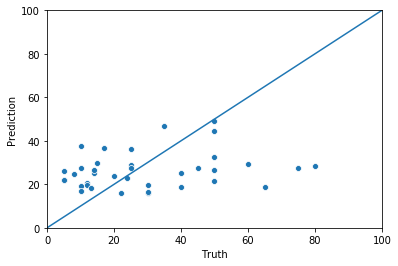

In [23]:
# Random Forest
model_evaluation(model_rfr, 'Random Forest Regression')

model_name Performance:
	Mean absolute error: 17.26
	Mean squared error: 467.75
	Coefficient of determination: -0.14
	A  -2.7 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 11.062818599251568


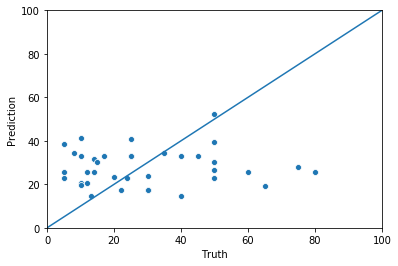

In [24]:
# AdaBoost
model_evaluation(model_ada, 'AdaBoosted Regression Trees')

# Investigating the edge cases

For those with low truth hourly rates, were they just under pricing themselves? Is my model finding that and recommending their real, competitive, hourly rate?

In [25]:
# Getting predicted values
X_test['preds'] = model_xgb.predict(xgb.DMatrix(X_test))

/Users/Metaverse/Desktop/Insight/projects/myrate/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# Merging into Data
dt = analysis_dt.merge(X_test['preds'], how = 'left', left_index=True, right_index=True)
dt['profile_url'] = profile_url
dt['error'] = dt['preds'] - dt['hourly_rate']

In [27]:
# Investigating people for whom the predicted was ~ 20 and the truth was ~ 5
display(dt.loc[(dt['error'] > 10), ['profile_url','hourly_rate','preds','error','hours_worked_pr_mnth_pst_yr']])
display(dt[(dt['error'] > 15)].profile_url.tolist())

# Largely, these seem to be people who are underpricing themselves relative to the rest of the market

,profile_url,hourly_rate,preds,error,hours_worked_pr_mnth_pst_yr
83,https://www.guru.com/freelancers/deinde-engine...,15.0,27.093578,12.093578,8.833333
122,https://www.guru.com/freelancers/rfadera,10.0,24.037251,14.037251,0.375000
264,https://www.guru.com/freelancers/barbara-vargas,5.0,23.208374,18.208374,6.050000
362,https://www.guru.com/freelancers/amale,5.0,17.808216,12.808216,19.333333
436,https://www.guru.com/freelancers/gabriel-mendoza,10.0,34.106674,24.106674,28.325000
437,https://www.guru.com/freelancers/bplanningcom,5.0,16.493439,11.493439,103.833333
527,https://www.guru.com/freelancers/harris-janoo,8.0,21.472385,13.472385,15.958333
895,https://www.guru.com/freelancers/donnell-l-davis,17.0,29.052677,12.052677,0.245098


['https://www.guru.com/freelancers/barbara-vargas',
 'https://www.guru.com/freelancers/gabriel-mendoza']

In [28]:
# Investigating people for whom the ground truth > 60 but predicted is ~30
display(dt.loc[(dt['error'] < -15), ['profile_url','hourly_rate','preds','error','hours_worked_pr_mnth_pst_yr']])
display(dt[(dt['error'] < -15)].profile_url.tolist())

,profile_url,hourly_rate,preds,error,hours_worked_pr_mnth_pst_yr
44,https://www.guru.com/freelancers/icemen,65.0,17.808216,-47.191784,20.352564
76,https://www.guru.com/freelancers/a1-digital-so...,60.0,22.402245,-37.597755,0.630556
111,https://www.guru.com/freelancers/wise-writing-...,30.0,9.906996,-20.093004,110.488889
139,https://www.guru.com/freelancers/the-quirky-cr...,50.0,18.030724,-31.969276,6.246667
146,https://www.guru.com/freelancers/rose-robinson,30.0,14.937656,-15.062344,1.388889
314,https://www.guru.com/freelancers/carolyn-fleming,40.0,10.029431,-29.970569,26.604167
359,https://www.guru.com/freelancers/big-whiskey-d...,45.0,26.646770,-18.353230,3.750000
524,https://www.guru.com/freelancers/michael-brand,80.0,24.834911,-55.165089,3.319792
650,https://www.guru.com/freelancers/robert-wooldr...,50.0,27.093578,-22.906422,0.416667
764,https://www.guru.com/freelancers/procutsediting,50.0,26.646770,-23.353230,0.875000


['https://www.guru.com/freelancers/icemen',
 'https://www.guru.com/freelancers/a1-digital-solutions-inc',
 'https://www.guru.com/freelancers/wise-writing-and-editing',
 'https://www.guru.com/freelancers/the-quirky-creative',
 'https://www.guru.com/freelancers/rose-robinson',
 'https://www.guru.com/freelancers/carolyn-fleming',
 'https://www.guru.com/freelancers/big-whiskey-design-studio',
 'https://www.guru.com/freelancers/michael-brand',
 'https://www.guru.com/freelancers/robert-wooldridge',
 'https://www.guru.com/freelancers/procutsediting',
 'https://www.guru.com/freelancers/bricasso',
 'https://www.guru.com/freelancers/ami-heida',
 'https://www.guru.com/freelancers/gemini-writing-services']

In [29]:
# Investigating people for whom the ground truth > 40 and the model does well on
display(dt.loc[(dt['error'] < 10) & (dt['hourly_rate'] > 40), ['profile_url','hourly_rate','preds','error', 'hours_worked_pr_mnth_pst_yr', 'programming & development', 'Arizona','49']])
display(dt[(dt['error'] < 10) & (dt['hourly_rate'] > 40)].profile_url.tolist())

,profile_url,hourly_rate,preds,error,hours_worked_pr_mnth_pst_yr,programming & development,Arizona,49
44,https://www.guru.com/freelancers/icemen,65.0,17.808216,-47.191784,20.352564,0,0,-0.412543
76,https://www.guru.com/freelancers/a1-digital-so...,60.0,22.402245,-37.597755,0.630556,0,0,-0.516559
139,https://www.guru.com/freelancers/the-quirky-cr...,50.0,18.030724,-31.969276,6.246667,0,0,-0.530330
359,https://www.guru.com/freelancers/big-whiskey-d...,45.0,26.646770,-18.353230,3.750000,0,0,-0.506787
524,https://www.guru.com/freelancers/michael-brand,80.0,24.834911,-55.165089,3.319792,0,0,-0.534942
650,https://www.guru.com/freelancers/robert-wooldr...,50.0,27.093578,-22.906422,0.416667,1,0,-0.438272
712,https://www.guru.com/freelancers/brian-zifac,50.0,37.543667,-12.456333,1.208333,1,1,-0.594031
764,https://www.guru.com/freelancers/procutsediting,50.0,26.646770,-23.353230,0.875000,0,0,-0.403135
796,https://www.guru.com/freelancers/bricasso,75.0,21.851847,-53.148153,0.355556,0,0,-0.366187
864,https://www.guru.com/freelancers/gemini-writin...,50.0,30.512424,-19.487576,0.175000,0,0,-0.458819


['https://www.guru.com/freelancers/icemen',
 'https://www.guru.com/freelancers/a1-digital-solutions-inc',
 'https://www.guru.com/freelancers/the-quirky-creative',
 'https://www.guru.com/freelancers/big-whiskey-design-studio',
 'https://www.guru.com/freelancers/michael-brand',
 'https://www.guru.com/freelancers/robert-wooldridge',
 'https://www.guru.com/freelancers/brian-zifac',
 'https://www.guru.com/freelancers/procutsediting',
 'https://www.guru.com/freelancers/bricasso',
 'https://www.guru.com/freelancers/gemini-writing-services']

In [30]:
dt[dt['profile_url'] == 'https://www.guru.com/freelancers/scopic']

,hourly_rate,bio_length,bio_word_count,avg_word_length,num_stop,administrative & secretarial,business & finance,design & art,education & training,engineering & architecture,...,43,44,45,46,47,48,49,preds,profile_url,error
0,24.0,1901,232,7.229437,43,0,0,0,0,0,...,-0.046579,-0.47547,-0.171319,-0.202593,0.092216,-0.39102,-0.543387,16.493439,https://www.guru.com/freelancers/scopic,-7.506561


In [39]:
display(dt.loc[(dt['error'] < 10), ['profile_url','hourly_rate','preds','error', 'hours_worked_pr_mnth_pst_yr', 'programming & development', 'Arizona','49']])


,profile_url,hourly_rate,preds,error,hours_worked_pr_mnth_pst_yr,programming & development,Arizona,49
0,https://www.guru.com/freelancers/scopic,24.0,16.493439,-7.506561,4632.927083,0,0,-0.543387
16,https://www.guru.com/freelancers/mxi-coders-inc,14.0,23.905052,9.905052,10.119048,0,0,-0.552120
24,https://www.guru.com/freelancers/empiricaledge,25.0,31.570053,6.570053,78.200000,1,0,-0.459040
44,https://www.guru.com/freelancers/icemen,65.0,17.808216,-47.191784,20.352564,0,0,-0.412543
58,https://www.guru.com/freelancers/jacquelyne-r-...,25.0,23.909218,-1.090782,0.983333,0,0,-0.468055
76,https://www.guru.com/freelancers/a1-digital-so...,60.0,22.402245,-37.597755,0.630556,0,0,-0.516559
108,https://www.guru.com/freelancers/ideas-girl,35.0,41.005421,6.005421,0.295238,1,0,-0.533950
111,https://www.guru.com/freelancers/wise-writing-...,30.0,9.906996,-20.093004,110.488889,0,0,-0.491412
139,https://www.guru.com/freelancers/the-quirky-cr...,50.0,18.030724,-31.969276,6.246667,0,0,-0.530330
146,https://www.guru.com/freelancers/rose-robinson,30.0,14.937656,-15.062344,1.388889,0,0,0.000000


# I can't seem to recreate embeddings other than "scopic" embedding

In [ ]:
# It is over-predicting for people who have largely undervalued themselves
# It is under-predicting for users with non-descriptive bios. For example, "icemen" has a descriptive that provides
# no detail as to their skillset. Because the bio is such an important feature this leads the algorithm to give them
# a low score.

In [31]:
# This extracts the embeddings at the sentence level and then averages across sentences within
# a document in order to obtain document (user) level embedding vector
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [32]:
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords  # Cleaning text data
from itertools import chain
import string

In [33]:
sql_query = """SELECT profile_url, bio from user_details_table;"""
bio_table = pd.read_sql_query(sql_query, con)
bio_table = bio_table.dropna() # Removing users with no bio
bio_table = bio_table.loc[bio_table.bio != "NA", :]

In [83]:
test = bio_table[bio_table['profile_url'] == '/freelancers/brian-zifac'].bio.tolist()[0]

# test = test.lower()
# test = test.split(' ')
# test = [x.translate(str.maketrans('', '', string.punctuation)) for x in test]
# stoplist = stopwords.words('english')
# tokenize_bio = [x for x in test if x not in stoplist]

filename = os.environ['PWD'] + '/scripts/models/model_w2v.sav'
model_w2v = pickle.load(open(filename, 'rb'))

words = model_w2v.wv.index2word
wvs = model_w2v.wv[words]

tokenize_bio = word_tokenize(test)

vocabulary = set(model_w2v.wv.index2word)
features = average_word_vectors(
    tokenize_bio, model_w2v, vocabulary, 50)

/Users/Metaverse/Desktop/Insight/projects/myrate/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [85]:
features

array([-0.42077449, -0.07662163,  0.13569045, -0.08428268, -0.32817699,
        0.14137182, -0.06305919, -0.33328595, -0.0759695 ,  0.46760826,
        0.19077872,  0.12795876,  0.3952278 ,  0.29264056,  0.23261189,
       -0.38902122,  0.26962409,  0.13032814, -0.19967935,  0.43575292,
        0.44278215,  0.02784485,  0.16412777,  0.07667711,  0.12081275,
       -0.52269501, -0.10199165,  0.43942632,  0.64236503,  0.39652776,
       -0.22247868, -0.36197536,  0.17872418, -0.11045579,  0.3400131 ,
       -0.42413153, -0.57363017, -0.29301109, -0.08529177, -0.14145789,
        0.11680008,  0.38181245,  0.45684208, -0.04436445, -0.42519121,
       -0.15354865, -0.17923097,  0.08181688, -0.34455691, -0.4861667 ])